<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

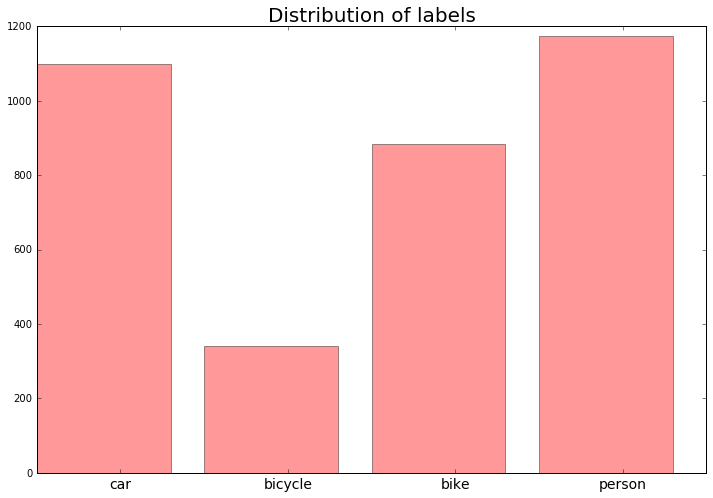

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [9]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [10]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [115]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, int(im.shape[1] * self.xi))
        yi = max(0, int(im.shape[0] * self.yi))
        xf = min(im.shape[1], int(im.shape[1] * self.xf))
        yf = min(im.shape[0], int(im.shape[0] * self.yf))
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [275]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.size, batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.size - i)):
            objs = annotations[i+j]
            im = imread(objs[0]['image'])
            old_size = im.shape
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [246]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j]
                im = imread(objs[0]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = 1.
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .3 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [13]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [353]:
Xtest,ytest = [t for t in generate_data_2(train_annotations[:1], C, batch_size=batch_size)][0]
Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)

In [356]:
net = {}
net['input'] = InputLayer((None,3,200,200), input_var=Xtest)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (3,3))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))


net['dense1'] = DenseLayer(dropout(net['pool4'], p=.0), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.0), (2 * 5 + 4) * (7*7))
net['output'] = DenseLayer(dropout(net['dense2'], p=.0), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [344]:
with open('pretrained_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [357]:
S = (7,7)
B = 2
C = 4

In [358]:
net['output'] = net['dense2']
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (2 * 5 + 4) * (7*7))

In [364]:
load_weights = True
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

ValueError: mismatch: got 26 values to set 24 parameters

<b>Train the network

In [360]:
num_epochs = 1000
batch_size = 50

In [361]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [362]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [365]:
cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

> /usr/local/python/bnr_ml/objectdetect/yolo.py(246)_get_cost_optim_multi()
-> return cost / T.maximum(1., truth.shape[0])
(Pdb) conf_is_zero.shape.eval()
array([1, 1, 2, 7, 7])
(Pdb) conf_is_zero[0,0].sum(axis=0).eval()
array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]])
(Pdb) conv_is_zero[0,0].eval()
*** NameError: name 'conv_is_zero' is not defined
(Pdb) conf_is_zero[0,0].eval()
array([[[1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0]],

       [[0, 0, 1, 1, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1]]])
(Pdb) lmbda_noobj 

BdbQuit: 

In [351]:
train_loss, test_loss = yl.train(
    generate_data_2(train_annotations[:1], C, batch_size=batch_size),
    generate_data_2(test_annotations[:1], C, batch_size=batch_size),
    lr=1e-3,
    epochs=num_epochs
)

Getting cost...
> /usr/local/python/bnr_ml/objectdetect/yolo.py(246)_get_cost_optim_multi()
-> return cost / T.maximum(1., truth.shape[0])
(Pdb) c
> /usr/local/python/bnr_ml/objectdetect/yolo.py(246)_get_cost_optim_multi()
-> return cost / T.maximum(1., truth.shape[0])
(Pdb) c
Creating cost variable took 2.9298 seconds
Compiling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Compiling functions took 29.0824 seconds
Beginning training...
171.508224487
Epoch 0
------
Train Loss: 171.5082, Test Loss: 189896.0781


  0%|          | 1/1000 [00:00<07:09,  2.33it/s]

139800.40625
Epoch 1
------
Train Loss: 139800.4062, Test Loss: 3455.7886


  0%|          | 2/1000 [00:00<06:40,  2.49it/s]

3170.33349609
Epoch 2
------
Train Loss: 3170.3335, Test Loss: 160.1635


  0%|          | 3/1000 [00:01<06:21,  2.61it/s]

169.376525879
Epoch 3
------
Train Loss: 169.3765, Test Loss: 147.2413


  0%|          | 4/1000 [00:01<06:06,  2.72it/s]

153.201248169
Epoch 4
------
Train Loss: 153.2012, Test Loss: 139.7189


  0%|          | 5/1000 [00:01<05:57,  2.78it/s]

146.515151978
Epoch 5
------
Train Loss: 146.5152, Test Loss: 135.3015


  1%|          | 6/1000 [00:02<05:49,  2.84it/s]

141.97895813
Epoch 6
------
Train Loss: 141.9790, Test Loss: 135.4256


  1%|          | 7/1000 [00:02<05:44,  2.88it/s]

141.874984741
Epoch 7
------
Train Loss: 141.8750, Test Loss: 134.8106


  1%|          | 8/1000 [00:02<05:41,  2.91it/s]

141.212173462
Epoch 8
------
Train Loss: 141.2122, Test Loss: 134.3925


  1%|          | 9/1000 [00:03<05:38,  2.93it/s]

140.793167114
Epoch 9
------
Train Loss: 140.7932, Test Loss: 134.3752


  1%|          | 10/1000 [00:03<05:36,  2.95it/s]

140.799591064
Epoch 10
------
Train Loss: 140.7996, Test Loss: 134.3467


  1%|          | 11/1000 [00:03<05:32,  2.97it/s]

140.776672363
Epoch 11
------
Train Loss: 140.7767, Test Loss: 134.3121


  1%|          | 12/1000 [00:04<05:33,  2.96it/s]

140.76373291
Epoch 12
------
Train Loss: 140.7637, Test Loss: 134.3093


  1%|▏         | 13/1000 [00:04<05:30,  2.98it/s]

140.761734009
Epoch 13
------
Train Loss: 140.7617, Test Loss: 134.3055


  1%|▏         | 14/1000 [00:04<05:29,  2.99it/s]

140.759841919
Epoch 14
------
Train Loss: 140.7598, Test Loss: 134.3042


  2%|▏         | 15/1000 [00:05<05:29,  2.99it/s]

140.757568359
Epoch 15
------
Train Loss: 140.7576, Test Loss: 134.2997


  2%|▏         | 16/1000 [00:05<05:28,  2.99it/s]

140.758529663
Epoch 16
------
Train Loss: 140.7585, Test Loss: 134.3052


  2%|▏         | 17/1000 [00:05<05:27,  3.00it/s]

140.762619019
Epoch 17
------
Train Loss: 140.7626, Test Loss: 134.3100


  2%|▏         | 18/1000 [00:06<05:26,  3.01it/s]

140.760070801
Epoch 18
------
Train Loss: 140.7601, Test Loss: 134.3131


  2%|▏         | 19/1000 [00:06<05:26,  3.00it/s]

140.760696411
Epoch 19
------
Train Loss: 140.7607, Test Loss: 134.3049


  2%|▏         | 20/1000 [00:06<05:27,  2.99it/s]

140.760360718
Epoch 20
------
Train Loss: 140.7604, Test Loss: 134.3157


  2%|▏         | 21/1000 [00:07<05:27,  2.99it/s]

140.765045166
Epoch 21
------
Train Loss: 140.7650, Test Loss: 134.3059


  2%|▏         | 22/1000 [00:07<05:26,  3.00it/s]

140.759841919
Epoch 22
------
Train Loss: 140.7598, Test Loss: 134.3021


  2%|▏         | 23/1000 [00:07<05:26,  2.99it/s]

140.762329102
Epoch 23
------
Train Loss: 140.7623, Test Loss: 134.3237


  2%|▏         | 24/1000 [00:08<05:26,  2.99it/s]

140.766326904
Epoch 24
------
Train Loss: 140.7663, Test Loss: 134.2853


  2%|▎         | 25/1000 [00:08<05:27,  2.98it/s]

140.780395508
Epoch 25
------
Train Loss: 140.7804, Test Loss: 134.7046


  3%|▎         | 26/1000 [00:08<05:25,  2.99it/s]

140.78565979
Epoch 26
------
Train Loss: 140.7857, Test Loss: 134.2158


  3%|▎         | 27/1000 [00:09<05:24,  3.00it/s]

140.779251099
Epoch 27
------
Train Loss: 140.7793, Test Loss: 134.8241


  3%|▎         | 28/1000 [00:09<05:26,  2.98it/s]

140.832611084
Epoch 28
------
Train Loss: 140.8326, Test Loss: 134.1795


  3%|▎         | 29/1000 [00:09<05:25,  2.99it/s]

140.812591553
Epoch 29
------
Train Loss: 140.8126, Test Loss: 134.9129


  3%|▎         | 30/1000 [00:10<05:24,  2.99it/s]

140.895172119
Epoch 30
------
Train Loss: 140.8952, Test Loss: 134.2778


  3%|▎         | 31/1000 [00:10<05:25,  2.98it/s]

140.802963257
Epoch 31
------
Train Loss: 140.8030, Test Loss: 134.4642


  3%|▎         | 32/1000 [00:10<05:26,  2.96it/s]

140.808517456
Epoch 32
------
Train Loss: 140.8085, Test Loss: 134.1974


  3%|▎         | 33/1000 [00:11<05:25,  2.97it/s]

140.796646118
Epoch 33
------
Train Loss: 140.7966, Test Loss: 134.8586


  3%|▎         | 34/1000 [00:11<05:24,  2.98it/s]

140.865432739
Epoch 34
------
Train Loss: 140.8654, Test Loss: 134.2077


  4%|▎         | 35/1000 [00:11<05:22,  2.99it/s]

140.788955688
Epoch 35
------
Train Loss: 140.7890, Test Loss: 134.7895


  4%|▎         | 36/1000 [00:12<05:22,  2.99it/s]

140.823547363
Epoch 36
------
Train Loss: 140.8235, Test Loss: 134.1883


  4%|▎         | 37/1000 [00:12<05:22,  2.99it/s]

140.812713623
Epoch 37
------
Train Loss: 140.8127, Test Loss: 134.9154


  4%|▍         | 38/1000 [00:12<05:21,  2.99it/s]

140.908920288
Epoch 38
------
Train Loss: 140.9089, Test Loss: 134.2585


  4%|▍         | 39/1000 [00:13<05:23,  2.97it/s]

140.796798706
Epoch 39
------
Train Loss: 140.7968, Test Loss: 134.4613


  4%|▍         | 40/1000 [00:13<05:22,  2.98it/s]

140.807739258
Epoch 40
------
Train Loss: 140.8077, Test Loss: 134.1569


  4%|▍         | 41/1000 [00:13<05:21,  2.98it/s]

140.816467285
Epoch 41
------
Train Loss: 140.8165, Test Loss: 134.9750


  4%|▍         | 42/1000 [00:14<05:21,  2.98it/s]

140.952957153
Epoch 42
------
Train Loss: 140.9530, Test Loss: 134.3079


  4%|▍         | 43/1000 [00:14<05:20,  2.98it/s]

140.777938843
Epoch 43
------
Train Loss: 140.7779, Test Loss: 134.2767


  4%|▍         | 44/1000 [00:14<05:20,  2.99it/s]

140.762069702
Epoch 44
------
Train Loss: 140.7621, Test Loss: 134.3115


  4%|▍         | 45/1000 [00:15<05:20,  2.98it/s]

140.75680542
Epoch 45
------
Train Loss: 140.7568, Test Loss: 134.1862


  5%|▍         | 46/1000 [00:15<05:19,  2.99it/s]

140.773040771
Epoch 46
------
Train Loss: 140.7730, Test Loss: 134.8658


  5%|▍         | 47/1000 [00:15<05:18,  3.00it/s]

140.872467041
Epoch 47
------
Train Loss: 140.8725, Test Loss: 134.1257


  5%|▍         | 48/1000 [00:16<05:17,  3.00it/s]

140.864715576
Epoch 48
------
Train Loss: 140.8647, Test Loss: 135.1329


  5%|▍         | 49/1000 [00:16<05:16,  3.00it/s]

141.437805176
Epoch 49
------
Train Loss: 141.4378, Test Loss: 134.9747


  5%|▌         | 50/1000 [00:16<05:18,  2.98it/s]

141.304458618
Epoch 50
------
Train Loss: 141.3045, Test Loss: 135.5167


  5%|▌         | 51/1000 [00:17<05:19,  2.97it/s]

141.227554321
Epoch 51
------
Train Loss: 141.2276, Test Loss: 135.3899


  5%|▌         | 52/1000 [00:17<05:18,  2.98it/s]

140.797775269
Epoch 52
------
Train Loss: 140.7978, Test Loss: 134.8239


  5%|▌         | 53/1000 [00:17<05:16,  2.99it/s]

140.802047729
Epoch 53
------
Train Loss: 140.8020, Test Loss: 135.7434


  5%|▌         | 54/1000 [00:18<05:17,  2.98it/s]

140.935852051
Epoch 54
------
Train Loss: 140.9359, Test Loss: 134.7812


  6%|▌         | 55/1000 [00:18<05:18,  2.97it/s]

140.833343506
Epoch 55
------
Train Loss: 140.8333, Test Loss: 134.9866


  6%|▌         | 56/1000 [00:18<05:17,  2.97it/s]

141.313262939
Epoch 56
------
Train Loss: 141.3133, Test Loss: 135.3251


  6%|▌         | 57/1000 [00:19<05:18,  2.96it/s]

140.849716187
Epoch 57
------
Train Loss: 140.8497, Test Loss: 134.8904


  6%|▌         | 58/1000 [00:19<05:17,  2.97it/s]

140.910064697
Epoch 58
------
Train Loss: 140.9101, Test Loss: 134.2155


  6%|▌         | 59/1000 [00:19<05:18,  2.96it/s]

140.917694092
Epoch 59
------
Train Loss: 140.9177, Test Loss: 135.3673


  6%|▌         | 60/1000 [00:20<05:16,  2.97it/s]

141.63117981
Epoch 60
------
Train Loss: 141.6312, Test Loss: 139.4264


  6%|▌         | 61/1000 [00:20<05:16,  2.96it/s]

145.049591064
Epoch 61
------
Train Loss: 145.0496, Test Loss: 134.6991


  6%|▌         | 62/1000 [00:20<05:16,  2.96it/s]

141.091552734
Epoch 62
------
Train Loss: 141.0916, Test Loss: 134.7570


  6%|▋         | 63/1000 [00:21<05:17,  2.95it/s]

141.40562439
Epoch 63
------
Train Loss: 141.4056, Test Loss: 135.9324


  6%|▋         | 64/1000 [00:21<05:16,  2.96it/s]

141.220535278
Epoch 64
------
Train Loss: 141.2205, Test Loss: 139.0693


  6%|▋         | 65/1000 [00:21<05:14,  2.97it/s]

145.464996338
Epoch 65
------
Train Loss: 145.4650, Test Loss: 135.3259


  7%|▋         | 66/1000 [00:22<05:13,  2.98it/s]

141.613006592
Epoch 66
------
Train Loss: 141.6130, Test Loss: 135.1346


  7%|▋         | 67/1000 [00:22<05:12,  2.98it/s]

141.005828857
Epoch 67
------
Train Loss: 141.0058, Test Loss: 133.7551


  7%|▋         | 68/1000 [00:22<05:11,  2.99it/s]

140.156478882
Epoch 68
------
Train Loss: 140.1565, Test Loss: 133.8136


  7%|▋         | 69/1000 [00:23<05:12,  2.98it/s]

140.123458862
Epoch 69
------
Train Loss: 140.1235, Test Loss: 133.6146


  7%|▋         | 70/1000 [00:23<05:12,  2.98it/s]

140.046524048
Epoch 70
------
Train Loss: 140.0465, Test Loss: 133.6225


  7%|▋         | 71/1000 [00:23<05:10,  2.99it/s]

140.036514282
Epoch 71
------
Train Loss: 140.0365, Test Loss: 133.5299


  7%|▋         | 72/1000 [00:24<05:12,  2.97it/s]

140.005157471
Epoch 72
------
Train Loss: 140.0052, Test Loss: 133.5537


  7%|▋         | 73/1000 [00:24<05:10,  2.98it/s]

139.994796753
Epoch 73
------
Train Loss: 139.9948, Test Loss: 133.4749


  7%|▋         | 74/1000 [00:24<05:10,  2.98it/s]

139.990814209
Epoch 74
------
Train Loss: 139.9908, Test Loss: 133.6400


  8%|▊         | 75/1000 [00:25<05:11,  2.97it/s]

140.01008606
Epoch 75
------
Train Loss: 140.0101, Test Loss: 133.3962


  8%|▊         | 76/1000 [00:25<05:09,  2.98it/s]

140.056488037
Epoch 76
------
Train Loss: 140.0565, Test Loss: 134.3101


  8%|▊         | 77/1000 [00:25<05:11,  2.97it/s]

140.571487427
Epoch 77
------
Train Loss: 140.5715, Test Loss: 133.9992


  8%|▊         | 78/1000 [00:26<05:10,  2.97it/s]

140.08001709
Epoch 78
------
Train Loss: 140.0800, Test Loss: 133.4901


  8%|▊         | 79/1000 [00:26<05:08,  2.98it/s]

140.016876221
Epoch 79
------
Train Loss: 140.0169, Test Loss: 133.7191


  8%|▊         | 80/1000 [00:26<05:09,  2.97it/s]

140.043121338
Epoch 80
------
Train Loss: 140.0431, Test Loss: 133.4207


  8%|▊         | 81/1000 [00:27<05:10,  2.96it/s]

140.102081299
Epoch 81
------
Train Loss: 140.1021, Test Loss: 134.4052


  8%|▊         | 82/1000 [00:27<05:09,  2.97it/s]

140.649658203
Epoch 82
------
Train Loss: 140.6497, Test Loss: 134.2040


  8%|▊         | 83/1000 [00:27<05:08,  2.97it/s]

140.501464844
Epoch 83
------
Train Loss: 140.5015, Test Loss: 133.8619


  8%|▊         | 84/1000 [00:28<05:07,  2.98it/s]

140.049377441
Epoch 84
------
Train Loss: 140.0494, Test Loss: 133.9852


  8%|▊         | 85/1000 [00:28<05:06,  2.99it/s]

140.039916992
Epoch 85
------
Train Loss: 140.0399, Test Loss: 133.4216


  9%|▊         | 86/1000 [00:28<05:07,  2.97it/s]

140.065765381
Epoch 86
------
Train Loss: 140.0658, Test Loss: 134.3603


  9%|▊         | 87/1000 [00:29<05:05,  2.99it/s]

140.270217896
Epoch 87
------
Train Loss: 140.2702, Test Loss: 133.7424


  9%|▉         | 88/1000 [00:29<05:04,  2.99it/s]

140.06439209
Epoch 88
------
Train Loss: 140.0644, Test Loss: 133.4308


  9%|▉         | 89/1000 [00:29<05:06,  2.97it/s]

140.048950195
Epoch 89
------
Train Loss: 140.0490, Test Loss: 134.3255


  9%|▉         | 90/1000 [00:30<05:05,  2.98it/s]

140.576843262
Epoch 90
------
Train Loss: 140.5768, Test Loss: 133.8813


  9%|▉         | 91/1000 [00:30<05:06,  2.97it/s]

140.015930176
Epoch 91
------
Train Loss: 140.0159, Test Loss: 133.8281


  9%|▉         | 92/1000 [00:30<05:05,  2.97it/s]

139.989074707
Epoch 92
------
Train Loss: 139.9891, Test Loss: 133.5556


  9%|▉         | 93/1000 [00:31<05:04,  2.98it/s]

139.979644775
Epoch 93
------
Train Loss: 139.9796, Test Loss: 133.4594


  9%|▉         | 94/1000 [00:31<05:05,  2.97it/s]

139.987930298
Epoch 94
------
Train Loss: 139.9879, Test Loss: 134.1053


 10%|▉         | 95/1000 [00:31<05:05,  2.96it/s]

140.083938599
Epoch 95
------
Train Loss: 140.0839, Test Loss: 133.5145


 10%|▉         | 96/1000 [00:32<05:05,  2.96it/s]

140.432571411
Epoch 96
------
Train Loss: 140.4326, Test Loss: 134.5629


 10%|▉         | 97/1000 [00:32<05:03,  2.98it/s]

140.807189941
Epoch 97
------
Train Loss: 140.8072, Test Loss: 135.1516


 10%|▉         | 98/1000 [00:32<05:02,  2.98it/s]

140.780975342
Epoch 98
------
Train Loss: 140.7810, Test Loss: 135.1341


 10%|▉         | 99/1000 [00:33<05:01,  2.99it/s]

140.776809692
Epoch 99
------
Train Loss: 140.7768, Test Loss: 135.1552


 10%|█         | 100/1000 [00:33<05:01,  2.99it/s]

140.784210205
Epoch 100
------
Train Loss: 140.7842, Test Loss: 135.1545


 10%|█         | 101/1000 [00:33<05:00,  2.99it/s]

140.783157349
Epoch 101
------
Train Loss: 140.7832, Test Loss: 135.1530


 10%|█         | 102/1000 [00:34<05:01,  2.97it/s]

140.780822754
Epoch 102
------
Train Loss: 140.7808, Test Loss: 135.1426


 10%|█         | 103/1000 [00:34<05:01,  2.98it/s]

140.770523071
Epoch 103
------
Train Loss: 140.7705, Test Loss: 135.6582


 10%|█         | 104/1000 [00:34<05:00,  2.98it/s]

141.363540649
Epoch 104
------
Train Loss: 141.3635, Test Loss: 135.5749


 10%|█         | 105/1000 [00:35<04:59,  2.99it/s]

141.247467041
Epoch 105
------
Train Loss: 141.2475, Test Loss: 135.1611


 11%|█         | 106/1000 [00:35<05:00,  2.97it/s]

140.791213989
Epoch 106
------
Train Loss: 140.7912, Test Loss: 134.9032


 11%|█         | 107/1000 [00:36<05:01,  2.96it/s]

140.47706604
Epoch 107
------
Train Loss: 140.4771, Test Loss: 134.8876


 11%|█         | 108/1000 [00:36<05:02,  2.95it/s]

140.468566895
Epoch 108
------
Train Loss: 140.4686, Test Loss: 134.8717


 11%|█         | 109/1000 [00:36<05:00,  2.96it/s]

140.464157104
Epoch 109
------
Train Loss: 140.4642, Test Loss: 135.0011


 11%|█         | 110/1000 [00:37<05:01,  2.96it/s]

140.460586548
Epoch 110
------
Train Loss: 140.4606, Test Loss: 135.2913


 11%|█         | 111/1000 [00:37<04:58,  2.97it/s]

140.859161377
Epoch 111
------
Train Loss: 140.8592, Test Loss: 135.5618


 11%|█         | 112/1000 [00:37<04:59,  2.96it/s]

141.774978638
Epoch 112
------
Train Loss: 141.7750, Test Loss: 185.9361


 11%|█▏        | 113/1000 [00:38<04:58,  2.98it/s]

179.9140625
Epoch 113
------
Train Loss: 179.9141, Test Loss: 136.2641


 11%|█▏        | 114/1000 [00:38<04:58,  2.96it/s]

143.561981201
Epoch 114
------
Train Loss: 143.5620, Test Loss: 139.3445


 12%|█▏        | 115/1000 [00:38<04:57,  2.97it/s]

145.737258911
Epoch 115
------
Train Loss: 145.7373, Test Loss: 135.2157


 12%|█▏        | 116/1000 [00:39<04:56,  2.98it/s]

141.329528809
Epoch 116
------
Train Loss: 141.3295, Test Loss: 134.7493


 12%|█▏        | 117/1000 [00:39<04:55,  2.99it/s]

141.199356079
Epoch 117
------
Train Loss: 141.1994, Test Loss: 135.2897


 12%|█▏        | 118/1000 [00:39<04:54,  2.99it/s]

141.702255249
Epoch 118
------
Train Loss: 141.7023, Test Loss: 134.0186


 12%|█▏        | 119/1000 [00:40<04:54,  2.99it/s]

140.248672485
Epoch 119
------
Train Loss: 140.2487, Test Loss: 134.2959


 12%|█▏        | 120/1000 [00:40<04:54,  2.99it/s]

140.474319458
Epoch 120
------
Train Loss: 140.4743, Test Loss: 134.2956


 12%|█▏        | 121/1000 [00:40<04:53,  3.00it/s]

140.473373413
Epoch 121
------
Train Loss: 140.4734, Test Loss: 134.2944


 12%|█▏        | 122/1000 [00:41<04:55,  2.98it/s]

140.47088623
Epoch 122
------
Train Loss: 140.4709, Test Loss: 134.2885


 12%|█▏        | 123/1000 [00:41<04:54,  2.98it/s]

140.472396851
Epoch 123
------
Train Loss: 140.4724, Test Loss: 134.2961


 12%|█▏        | 124/1000 [00:41<04:52,  2.99it/s]

140.474914551
Epoch 124
------
Train Loss: 140.4749, Test Loss: 134.2961


 12%|█▎        | 125/1000 [00:42<04:52,  2.99it/s]

140.474853516
Epoch 125
------
Train Loss: 140.4749, Test Loss: 134.2960


 13%|█▎        | 126/1000 [00:42<04:53,  2.98it/s]

140.474761963
Epoch 126
------
Train Loss: 140.4748, Test Loss: 134.2960


 13%|█▎        | 127/1000 [00:42<04:54,  2.97it/s]

140.474624634
Epoch 127
------
Train Loss: 140.4746, Test Loss: 134.2959


 13%|█▎        | 128/1000 [00:43<04:52,  2.98it/s]

140.474380493
Epoch 128
------
Train Loss: 140.4744, Test Loss: 134.2957


 13%|█▎        | 129/1000 [00:43<04:52,  2.98it/s]

140.473861694
Epoch 129
------
Train Loss: 140.4739, Test Loss: 134.2949


 13%|█▎        | 130/1000 [00:43<04:52,  2.97it/s]

140.472137451
Epoch 130
------
Train Loss: 140.4721, Test Loss: 134.2867


 13%|█▎        | 131/1000 [00:44<04:51,  2.98it/s]

140.470947266
Epoch 131
------
Train Loss: 140.4709, Test Loss: 134.2960


 13%|█▎        | 132/1000 [00:44<04:51,  2.98it/s]

140.474395752
Epoch 132
------
Train Loss: 140.4744, Test Loss: 134.2959


 13%|█▎        | 133/1000 [00:44<04:51,  2.97it/s]

140.474014282
Epoch 133
------
Train Loss: 140.4740, Test Loss: 134.2956


 13%|█▎        | 134/1000 [00:45<04:50,  2.98it/s]

140.473190308
Epoch 134
------
Train Loss: 140.4732, Test Loss: 134.2946


 14%|█▎        | 135/1000 [00:45<04:51,  2.97it/s]

140.471008301
Epoch 135
------
Train Loss: 140.4710, Test Loss: 134.2886


 14%|█▎        | 136/1000 [00:45<04:50,  2.98it/s]

140.444030762
Epoch 136
------
Train Loss: 140.4440, Test Loss: 134.4240


 14%|█▎        | 137/1000 [00:46<04:49,  2.98it/s]

140.630218506
Epoch 137
------
Train Loss: 140.6302, Test Loss: 133.4119


 14%|█▍        | 138/1000 [00:46<04:49,  2.98it/s]

140.165115356
Epoch 138
------
Train Loss: 140.1651, Test Loss: 183.2829


 14%|█▍        | 139/1000 [00:46<04:48,  2.98it/s]

174.319869995
Epoch 139
------
Train Loss: 174.3199, Test Loss: 142.4833


 14%|█▍        | 140/1000 [00:47<04:48,  2.98it/s]

145.495361328
Epoch 140
------
Train Loss: 145.4954, Test Loss: 132.8938


 14%|█▍        | 141/1000 [00:47<04:49,  2.97it/s]

138.259963989
Epoch 141
------
Train Loss: 138.2600, Test Loss: 132.8167


 14%|█▍        | 142/1000 [00:47<04:48,  2.97it/s]

138.13470459
Epoch 142
------
Train Loss: 138.1347, Test Loss: 132.8059


 14%|█▍        | 143/1000 [00:48<04:49,  2.96it/s]

138.145294189
Epoch 143
------
Train Loss: 138.1453, Test Loss: 132.8179


 14%|█▍        | 144/1000 [00:48<04:49,  2.96it/s]


In [355]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [302]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

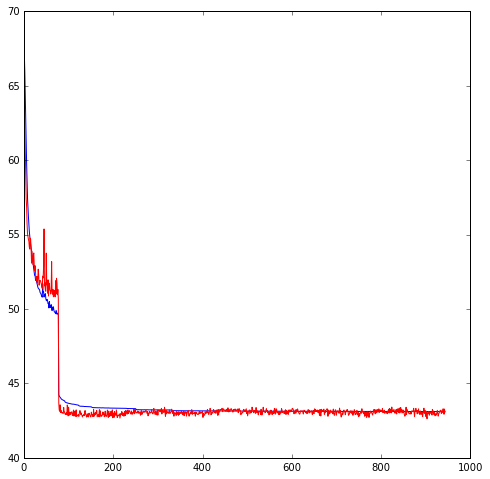

In [191]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [192]:
gen = generate_data_2(test_annotations[100:200], C, max_objs=1)

In [193]:
testdat = [t for t in gen]

In [194]:
Xtest, ytest = testdat[0]

In [195]:
out_fn = theano.function([yl.input], yl.output_test)

In [196]:
Xtest_out = out_fn(Xtest)

In [197]:
def draw_coord(im, coord, idx):
    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)
    
    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    return draw_im

In [198]:
def draw_best(im, output, num=None, thresh=.3):
    im = np.copy(im)
    objectness = output[[4,9]] * output[-C:].max()
    isgreater = objectness[objectness > thresh].size
    idxs = objectness.flatten().argsort()[::-1]
    for i in range(isgreater):
        idx = idxs[i]
        idx = np.unravel_index(idx, objectness.shape)
        coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
        im = draw_coord(im, coord, idx)
        
    print objectness.max()
    print objectness[np.unravel_index(idxs[0], objectness.shape)]
    return im
        

In [199]:
def draw_best_one(im, output):
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = min(im.shape[1]-1, max(0, xi)), min(im.shape[1]-1, max(0, yi))
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [200]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [201]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [214]:
N = int(Xtest.shape[0] * np.random.rand())
# N = 20
print N
a = draw_best(swap(Xtest[N]), Xtest_out[N], thresh=.2)

44
0.499895
0.499895


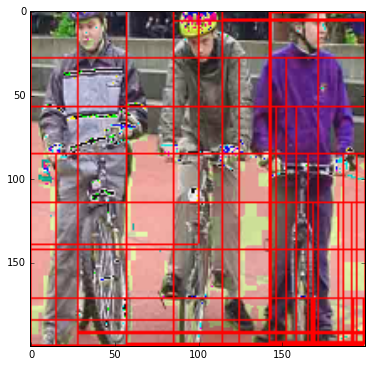

In [215]:
plt.figure(figsize=(6,6))
plt.imshow(a)
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [772]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)